In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

## read data

In [4]:
path = os.path.join('data','balanced_data.csv')
news_data = pd.read_csv(path,usecols=[1,2,3,4,5,6,7]) 
news_data.tail()

,url,source,title,author,text,authenticity,label_num
1994,http://www.bighairynews.com/2017/07/military-t...,Bighairynews,Military Trannies Trumped,[],WASHINGTON (World News Bureau) - President Tru...,0,1
1995,http://bipartisanreport.com/2017/07/27/scaramu...,bipartisanreport,Scaramucci Responds To Article About His Profa...,['Holly Lee'],Anthony Scaramucci is facing serious scorn aft...,0,1
1996,https://amgreatness.com/2017/07/19/muellers-in...,wordpress,Mueller’s Investigation Must Be Limited and Ac...,"['Andrew C. Mccarthy', 'Sam Mcgowan', 'Bill S'...",How much goalpost moving should be tolerable i...,0,1
1997,http://www.politico.com/story/2017/07/26/scara...,wordpress,Scaramucci still stands to profit from SkyBrid...,"['Lorraine Woellert', 'Cristiano Lima', 'Tara ...",The incoming White House communications direct...,0,1
1998,http://beforeitsnews.com/health/2017/07/how-po...,beforeitsnews,How potatoes can increase the risk of cancer c...,['Natural Health'],(Before It's News)\n\n(NaturalHealth365) A rec...,0,1


## convert text to numbers (features)

### split data

In [5]:
from sklearn.cross_validation import train_test_split

//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
x = news_data.text
y = news_data.label_num

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1499,)
(500,)
(1499,)
(500,)


In [8]:
y_train.value_counts()

1    752
0    747
Name: label_num, dtype: int64

### use TF-IDF to generate features

In [9]:
# customized tokenize function for stemming and removing punctuation
import nltk
import string
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize_stemmer(text):
    tokens = nltk.word_tokenize(text)
    tokens = [i for i in tokens if i not in string.punctuation]
    stems = stem_tokens(tokens, stemmer)
    return stems

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(tokenizer=tokenize_stemmer,stop_words='english',ngram_range=(2, 2))
tfidf

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(2, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenize_stemmer at 0x11c88ac80>, use_idf=True,
        vocabulary=None)

In [11]:
x_train_dtm = tfidf.fit_transform(x_train)

# examine the document-term matrix
x_train_dtm

<1499x426602 sparse matrix of type '<class 'numpy.float64'>'
	with 555729 stored elements in Compressed Sparse Row format>

In [12]:
x_test_dtm = tfidf.transform(x_test)
x_test_dtm

<500x426602 sparse matrix of type '<class 'numpy.float64'>'
	with 61527 stored elements in Compressed Sparse Row format>

### examine top features 
codes are taken from https://buhrmann.github.io/tfidf-analysis.html

In [13]:
def top_tfidf_features(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_features_in_doc(x_train_dtm, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(x_train_dtm[row_id].toarray())
    return top_tfidf_features(row, features, top_n)

def top_mean_features(x_train_dtm, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = x_train_dtm[grp_ids].toarray()
    else:
        D = x_train_dtm.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_features(tfidf_means, features, top_n)

def top_features_by_class(x_train_dtm, y_train, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y_train)
    for label in labels:
        ids = np.where(y_train==label)
        features_df = top_mean_features(x_train_dtm, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        features_df.label = label
        dfs.append(features_df)
    return dfs

def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

In [14]:
features = tfidf.get_feature_names()

In [16]:
# top features in first document
#top_features_in_doc(x_train_dtm, features, 0)

In [17]:
# top features across the whole corpus
top_features = top_mean_features(x_train_dtm, features,top_n=10)
top_features

,feature,tfidf
0,white hous,0.003125
1,'' '',0.002686
2,north korea,0.001994
3,boy scout,0.001644
4,attorney gener,0.001494
5,special counsel,0.001493
6,'' said,0.001447
7,health care,0.001232
8,'' say,0.001158
9,climat chang,0.001096


In [16]:
print(top_features.feature.tolist)

<bound method Series.tolist of 0         white hous
1              '' ''
2        north korea
3          boy scout
4     attorney gener
5    special counsel
6            '' said
7        health care
8             '' say
9       climat chang
Name: feature, dtype: object>


In [19]:
top_features = top_features_by_class(x_train_dtm, y_train, features,top_n=10)
top_features

[          feature     tfidf
 0           '' ''  0.005131
 1      white hous  0.003633
 2         '' said  0.002904
 3          '' say  0.002065
 4  imag copyright  0.002064
 5     health care  0.002053
 6  laughter sagal  0.001909
 7         cb news  0.001902
 8  attorney gener  0.001900
 9    imag caption  0.001857,              feature     tfidf
 0         white hous  0.002620
 1    special counsel  0.002354
 2        north korea  0.002182
 3       presid trump  0.001781
 4          fake news  0.001727
 5          doug gile  0.001686
 6    washington post  0.001679
 7  wasserman schultz  0.001627
 8          boy scout  0.001510
 9         small busi  0.001404]

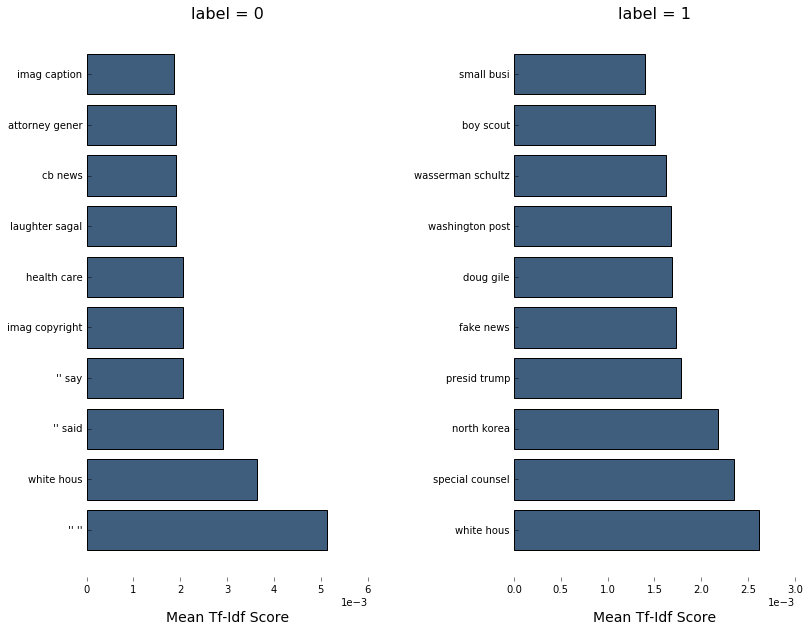

In [22]:
plot_tfidf_classfeats_h(top_features)